Aravind Patnam
Jeremy Tan
Timothy Le

CSE-184 Final Project - Trending Here Trending There 
An analysis on trending and nontrending Youtube videos. 

In [121]:
## imports


import sys
import pandas as pd
import numpy as np
import random
import requests
import json
import matplotlib.pyplot as plt
import time
from nltk.book import *
from nltk.corpus import stopwords
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import random
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
sns.set_context('notebook')
import warnings
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

In [122]:
## written by Aravind Patnam and Jeremy Tan

#### get all csv dataframes for trending. These files should be in the same directory. 
US_trending_df = pd.read_csv('USvideos.csv') #USA
CA_trending_df = pd.read_csv('CAvideos.csv') #CANADA
DE_trending_df = pd.read_csv('DEvideos.csv') #GERMANY
FR_trending_df = pd.read_csv('FRvideos.csv') #FRANCE
GB_trending_df = pd.read_csv('GBvideos.csv') #GREAT BRITAIN
IN_trending_df = pd.read_csv('INvideos.csv') #INDIA
JP_trending_df = pd.read_csv('JPvideos.csv', encoding='ISO-8859-1') #JAPAN
KR_trending_df = pd.read_csv('KRvideos.csv' , encoding='ISO-8859-1') #SOUTH KOREA
MX_trending_df = pd.read_csv('MXvideos.csv', encoding='ISO-8859-1') #MEXICO
RU_trending_df = pd.read_csv('RUvideos.csv', encoding='ISO-8859-1') #RUSSIA

list_of_all_trending_dfs = [US_trending_df, CA_trending_df, DE_trending_df, FR_trending_df, GB_trending_df, IN_trending_df,
                           JP_trending_df, KR_trending_df, MX_trending_df, RU_trending_df]
full_trending_df = pd.concat(list_of_all_trending_dfs)

In [123]:
## written by Aravind Patnam

## run these to get the non trending datasets generated from the youtube api. These files should be in the same directory
import pandas as pd
not_trending_us_df = pd.read_csv('not_trending_us_df.csv')
not_trending_ca_df = pd.read_csv('not_trending_ca_df.csv')
not_trending_de_df = pd.read_csv('not_trending_de_df.csv')
not_trending_fr_df = pd.read_csv('not_trending_fr_df.csv')
not_trending_gb_df = pd.read_csv('not_trending_gb_df.csv')
not_trending_in_df = pd.read_csv('not_trending_in_df.csv')
not_trending_jp_df = pd.read_csv('not_trending_jp_df.csv')
not_trending_kr_df = pd.read_csv('not_trending_kr_df.csv')
not_trending_mx_df = pd.read_csv('not_trending_mx_df.csv')
not_trending_ru_df = pd.read_csv('not_trending_ru_df.csv')

In [162]:
## written by Aravind Patnam

### do not run this unless you have about 1 hour and 10 Youtube API keys and a lot of time!!! Use above already generated datasets for testing. 
f = open("apiKey", "r")
key = f.read()
## for each videoId, find a related video
def do_search_youtube_request(videoId):
    url = "https://www.googleapis.com/youtube/v3/search?part=snippet&maxResults=50&order=relevance&relatedToVideoId={}&type=video&videoDefinition=any&key={}".format(videoId, key)
    r = requests.get(url)
    return r

## given a set of videoIds, find insights (statistics, tags, etc)
def find_video_insights(videoIds):
    print(videoIds)
    url = 'https://www.googleapis.com/youtube/v3/videos?part=snippet%2CcontentDetails%2Cstatistics&id={}&key={}'.format(videoIds, key)
    r = requests.get(url)
    return r

## call this with 1 country at a time 
def process_youtube_requests(videoIds):
    df = pd.DataFrame(columns=['video_id', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 
                               'views', 'likes', 'dislikes', 'comment_count', 'description'])
    relatedVideoIds = []
    for videoId in videoIds:
        try: 
            response = do_search_youtube_request(videoId)
            time.sleep(2)
            if (response.status_code == 200):
                r1 = response.json()
                relatedVideoIdItems = r1['items']
                for id in relatedVideoIdItems:
                    relatedVideoId = id['id']['videoId']
                    relatedVideoIds.append(str(relatedVideoId))
            else:
                print(response.status_code)
        except:
            print ("Something went wrong here! 2")
    random.shuffle(relatedVideoIds)
    videoIdsForInsights = []
    for i in range(0, len(relatedVideoIds), 50):
        videoIdsForInsights.append(relatedVideoIds[i:i + n])
    for videoIdList in videoIdsForInsights:
        videoIdsStr = '%2C'.join([str(elem) for elem in videoIdList])
        r2 = find_video_insights(videoIdsStr)
        time.sleep(2)
        if (r2.status_code == 200):
            r = r2.json()
            i = 0
            while (i < len(videoIdList)):
                try:
                    id = videoIdList[i]
                    title = (r['items'][i]['snippet']['title'])
                    channel_title = (r['items'][i]['snippet']['channelTitle'])
                    category_id = (r['items'][i]['snippet']['categoryId'])
                    publish_time = (r['items'][i]['snippet']['publishedAt'])
                    tags = '|'.join((r['items'][i]['snippet']['tags']))
                    views = (r['items'][i]['statistics']['viewCount'])
                    likes = (r['items'][i]['statistics']['likeCount'])
                    dislikes = (r['items'][i]['statistics']['dislikeCount'])
                    comment_count = (r['items'][i]['statistics']['commentCount'])
                    description = (r['items'][i]['snippet']['description'])
                    data = {'video_id': id, 'title': title, 'channel_title': channel_title, 'category_id' : category_id,
                           'publish_time' : publish_time, 'tags' : tags, 'views' : views, 'likes' : likes, 'dislikes' : dislikes,
                           'comment_count' : comment_count, 'description' : description}
                    df = df.append(data, ignore_index = True)
                except:
                    print("Something went wrong! 3")
                i = i + 1
        else:
            print("Something went wrong! 4")
            print (r2.status_code)
            print(r2.text)
    return df     

In [149]:
## written by Aravind Patnam

### do not run this unless you have a lot of time and 10 Youtube API keys!!!. Datasets are already generated for you for testing. 
n = 50
US_trending_videoIds = US_trending_df.sample(n)['video_id'].tolist()
CA_trending_videoIds = CA_trending_df.sample(n)['video_id'].tolist()
DE_trending_videoIds = DE_trending_df.sample(n)['video_id'].tolist()
FR_trending_videoIds = FR_trending_df.sample(n)['video_id'].tolist()
GB_trending_videoIds = GB_trending_df.sample(n)['video_id'].tolist()
IN_trending_videoIds = IN_trending_df.sample(n)['video_id'].tolist()
JP_trending_videoIds = JP_trending_df.sample(n)['video_id'].tolist()
KR_trending_videoIds = KR_trending_df.sample(n)['video_id'].tolist()
MX_trending_videoIds = MX_trending_df.sample(n)['video_id'].tolist()
RU_trending_videoIds = RU_trending_df.sample(n)['video_id'].tolist()

In [ ]:
## written by Aravind Patnam
### do not run this unless you have a lot of time and 10 Youtube API keys!!! Datasets are already generated for you for testing. 
## do following requests separately with a new API Key
not_trending_us_df = process_youtube_requests(US_trending_videoIds)
not_trending_ca_df = process_youtube_requests(CA_trending_videoIds)
not_trending_de_df = process_youtube_requests(DE_trending_videoIds)
not_trending_fr_df = process_youtube_requests(FR_trending_videoIds)
not_trending_gb_df = process_youtube_requests(GB_trending_videoIds)
not_trending_in_df = process_youtube_requests(IN_trending_videoIds)
not_trending_jp_df = process_youtube_requests(JP_trending_videoIds)
not_trending_kr_df = process_youtube_requests(KR_trending_videoIds)
not_trending_mx_df = process_youtube_requests(MX_trending_videoIds)
not_trending_ru_df = process_youtube_requests(RU_trending_videoIds)

In [124]:
## written by Aravind Patnam

## puts all nontrending and all dfs that we have together for one big df and multiple smaller ones
list_of_all_nontrending_dfs = [not_trending_us_df, not_trending_ca_df, not_trending_de_df, 
                              not_trending_fr_df, not_trending_gb_df, not_trending_in_df, not_trending_jp_df,
                              not_trending_kr_df, not_trending_mx_df, not_trending_ru_df]


full_nontrending_df = pd.concat(list_of_all_nontrending_dfs)
allDfsList = list_of_all_trending_dfs + list_of_all_nontrending_dfs + [full_trending_df] + [full_nontrending_df]
allDfsDf = pd.concat(allDfsList)
allDfsList.append(allDfsDf)

In [125]:
## written by Jeremy Tan

## inserts category field into each dataframe from given json file
def insert_category_field(df):
    # add a category column using the category id from the json file
    id_to_category = {}
    with open("US_category_id.json", 'r') as f: # the other category json files have missing category ids. We decided to just use the US file since it contained all of them and since they are standard internationally. 
        data = json.load(f)
        for category in data['items']:
            id_to_category[category['id']] = category['snippet']['title']
        categories = []
        for id in list(df['category_id']):
            categories.append(id_to_category[str(id)])
        df.insert(4, 'category', categories)

In [126]:
## written by Jeremy Tan

## insert new category field into dataframes
for df in allDfsList:
    insert_category_field(df)

In [127]:
## written by Jeremy Tan

## converts all columns in dataframes to type for analysis
for df in list_of_all_nontrending_dfs:
    df['video_id'] = df['video_id'].astype(str) 
    df['title'] = df['title'].astype(str)
    df['channel_title'] = df['channel_title'].astype(str)
    df['category_id'] = df['category_id'].astype(int)
    df['category'] = df['category'].astype(str)
    df['tags'] = df['tags'].astype(str)
    df['views'] = df['views'].astype(int)
    df['likes'] = df['likes'].astype(int)
    df['dislikes'] = df['dislikes'].astype(int)
    df['comment_count'] = df['comment_count'].astype(int)
    df['description'] = df['description'].astype(str)

In [128]:
## written by Aravind Patnam

## method to find stats about a given country df
def find_stats(df):
    views = df['views']
    likes = df['likes']
    dislikes = df['dislikes']
    comment_count = df['comment_count']
    tags = list(df['tags'])
    tagsList = []
    for t in tags: 
        tagsList.append(len(t.split('|')))
    viewsStats = [views.sum(), views.sum() / len(views), views.min(), views.max()]
    likesStats = [likes.sum(), likes.sum() / len(likes), likes.min(), likes.max()]
    dislikesStats = [dislikes.sum(), dislikes.sum() / len(dislikes), dislikes.min(), dislikes.max()]
    commentsStats = [comment_count.sum(), comment_count.sum() / len(comment_count), comment_count.min(), comment_count.max()]
    tagsStats = [sum(tagsList), sum(tagsList) / len(tagsList), min(tagsList), max(tagsList)]
    statsDf = pd.DataFrame({'views': viewsStats, 'likes': likesStats, 'dislikes': dislikesStats, 'comment_count': commentsStats, 'tags': tagsStats}, index = ['count', 'mean', 'min', 'max']) 
    return statsDf

In [129]:
## written by Aravind Patnam

## output is a map containing all the numeric data for each df
describes = []
for df in allDfsList:
    describes.append(find_stats(df))
describesKeys = ['US_trending_df', 'CA_trending_df', 'DE_trending_df', 'FR_trending_df', 'GB_trending_df',
                'IN_trending_df', 'JP_trending_df', 'KR_trending_df', 'MX_trending_df', 'RU_trending_df',
                 'not_trending_us_df', 'not_trending_ca_df', 'not_trending_de_df', 'not_trending_fr_df',
                'not_trending_gb_df', 'not_trending_in_df', 'not_trending_jp_df', 'not_trending_kr_df',
                 'not_trending_mx_df', 'not_trending_ru_df',
                'full_trending_df', 'full_nontrending_df', 'allDfsDf']
describeMap = dict(zip(describesKeys, describes))

In [130]:
## written by Aravind Patnam

## map of numeric stats of each df
describeMap
## find stats on a specific country: describeMap['US_trending_df']
### lets visualize this since this is all our numeric data!! 

{'US_trending_df':               views         likes      dislikes  comment_count           tags
 count  9.667177e+10  3.041147e+09  1.519782e+08   3.458882e+08  808183.000000
 mean   2.360785e+06  7.426670e+04  3.711401e+03   8.446804e+03      19.736331
 min    5.490000e+02  0.000000e+00  0.000000e+00   0.000000e+00       1.000000
 max    2.252119e+08  5.613827e+06  1.674420e+06   1.361580e+06      69.000000,
 'CA_trending_df':               views         likes      dislikes  comment_count           tags
 count  4.689198e+10  1.618180e+09  8.213792e+07   2.061618e+08  800372.000000
 mean   1.147036e+06  3.958269e+04  2.009195e+03   5.042975e+03      19.578093
 min    7.330000e+02  0.000000e+00  0.000000e+00   0.000000e+00       1.000000
 max    1.378431e+08  5.053338e+06  1.602383e+06   1.114800e+06     124.000000,
 'DE_trending_df':               views         likes      dislikes  comment_count           tags
 count  2.464512e+10  8.933955e+08  5.705903e+07   1.137744e+08  733959.000

In [134]:
## written by Aravind Patnam

## make sense of each data point we have from the describeMap and clean it for visualization
countries = list(describeMap.keys())
views_count = []
views_mean = []
views_max = []
views_min = []
likes_count = []
likes_mean = []
likes_max = []
likes_min = []
dislikes_count = []
dislikes_mean = []
dislikes_max = []
dislikes_min = []

comments_mean = []
comments_max = []
comments_min = []

tags_mean = []
tags_max = []
tags_min = []

for a in countries:
    views_count.append(describeMap[a].loc['count', 'views'])
    views_mean.append(describeMap[a].loc['mean', 'views'])
    views_max.append(describeMap[a].loc['max', 'views'])
    views_min.append(describeMap[a].loc['min', 'views'])
    
    likes_count.append(describeMap[a].loc['count', 'likes'])
    likes_mean.append(describeMap[a].loc['mean', 'likes'])
    likes_max.append(describeMap[a].loc['max', 'likes'])
    likes_min.append(describeMap[a].loc['min', 'likes'])
    
    dislikes_count.append(describeMap[a].loc['count', 'dislikes'])
    dislikes_mean.append(describeMap[a].loc['mean', 'dislikes'])
    dislikes_max.append(describeMap[a].loc['max', 'dislikes'])
    dislikes_min.append(describeMap[a].loc['min', 'dislikes'])
    
    comments_mean.append(describeMap[a].loc['mean', 'comment_count'])
    comments_max.append(describeMap[a].loc['max', 'comment_count'])
    comments_min.append(describeMap[a].loc['min', 'comment_count'])
    
    tags_mean.append(describeMap[a].loc['mean', 'tags'])
    tags_max.append(describeMap[a].loc['max', 'tags'])
    tags_min.append(describeMap[a].loc['min', 'tags'])

Hover over the bar graphs to play with them and see what each one represents!!

In [135]:
## written by Aravind Patnam

# visualize above numeric data

import bokeh
from bokeh.io import show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import HoverTool, ColorBar, NumeralTickFormatter, LinearColorMapper, LassoSelectTool, ResetTool, PanTool, BoxSelectTool, TapTool, PolySelectTool

bokeh.io.reset_output()
bokeh.io.output_notebook()



countries = describesKeys
categories = ['views_mean', 'views_max', 'views_min']
categoriesLikes = ['likes_mean', 'likes_max', 'likes_min']
categoriesDislikes = ['dislikes_mean', 'dislikes_max', 'dislikes_min']
categoriesComments = ['comments_mean', 'comments_max', 'comments_min']
categoriesTags = ['tags_mean', 'tags_max', 'tags_min']

data = {'countries' : countries,
        'views_mean': views_mean,
        'views_max':views_max, 
        'views_min':views_min }
dataLikes = {'countries' : countries, 'likes_mean' : likes_mean, 'likes_max': likes_max, 'likes_min' : likes_min}

dataDislikes = {'countries' : countries, 'dislikes_mean' : dislikes_mean, 'dislikes_max' : dislikes_max, 'dislikes_min': dislikes_min}

dataComments = {'countries' : countries, 'comments_mean' : comments_mean, 'comments_max' : comments_max, 'comments_min': comments_min}

dataTags = {'countries' : countries, 'tags_mean' : tags_mean, 'tags_max': tags_max, 'tags_min' : tags_min}




# this creates [ ("Apples", "2015"), ("Apples", "2016"), ("Apples", "2017"), ("Pears", "2015), ... ]
x = [ (c, category) for c in countries for category in categories ]
# print (len(x))
yLikes = [(c, l) for c in countries for l in categoriesLikes]
yDislikes = [(c, h) for c in countries for h in categoriesDislikes]

yComments = [(c, comms) for c in countries for comms in categoriesComments]

yTags = [(c, ts) for c in countries for ts in categoriesTags]



counts = sum(zip(data['views_mean'], data['views_max'], data['views_min']), ()) # like an hstack
countsLikes = sum(zip(dataLikes['likes_mean'], dataLikes['likes_max'], dataLikes['likes_min']), ()) # like an hstack
countsDislikes = sum(zip(dataDislikes['dislikes_mean'], dataDislikes['dislikes_max'], dataDislikes['dislikes_min']), ())
countsComments = sum(zip(dataComments['comments_mean'], dataComments['comments_max'], dataComments['comments_min']), ())

countsTags = sum(zip(dataTags['tags_mean'], dataTags['tags_max'], dataTags['tags_min']), ())




source = ColumnDataSource(data=dict(x=x, counts=counts))
sourceLikes = ColumnDataSource(data=dict(x=yLikes, counts=countsLikes))
sourceDislikes = ColumnDataSource(data=dict(x=yDislikes, counts=countsDislikes))

sourceComments = ColumnDataSource(data=dict(x=yComments, counts=countsComments))

sourceTags = ColumnDataSource(data=dict(x=yTags, counts=countsTags))


hover = HoverTool()

hover.tooltips = [
    ("(x,y)", "($x, $y)"),
    ("Country", "@x"),
    ("Stat" , "@counts")
]

p = figure(x_range=FactorRange(*x), plot_height=250, plot_width=3000, title="Views Counts Per Country Trending/NonTrending",
           toolbar_location=None, tools = [BoxSelectTool(), LassoSelectTool(), ResetTool(), hover, TapTool(), PolySelectTool()])

p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
       fill_color=factor_cmap('x', palette=Spectral6, factors=categories, start=1, end=2))


p1 = figure(x_range=FactorRange(*yLikes), plot_height=250, plot_width=3000, title="Likes Counts Per Country Trending/NonTrending",
           toolbar_location=None, tools = [BoxSelectTool(), LassoSelectTool(), ResetTool(), hover, TapTool(), PolySelectTool()])

p1.vbar(x='x', top='counts', width=0.9, source=sourceLikes, line_color="white",
       fill_color=factor_cmap('x', palette=Spectral6, factors=categoriesLikes, start=1, end=2))


p2 = figure(x_range=FactorRange(*yDislikes), plot_height=250, plot_width=3000, title="Dislikes Counts Per Country Trending/NonTrending",
           toolbar_location=None, tools = [BoxSelectTool(), LassoSelectTool(), ResetTool(), hover, TapTool(), PolySelectTool()])

p2.vbar(x='x', top='counts', width=0.9, source=sourceDislikes, line_color="white",
       fill_color=factor_cmap('x', palette=Spectral6, factors=categoriesDislikes, start=1, end=2))



p3 = figure(x_range=FactorRange(*yComments), plot_height=250, plot_width=3000, title="Comment Counts Per Country Trending/NonTrending",
           toolbar_location=None, tools = [BoxSelectTool(), LassoSelectTool(), ResetTool(), hover, TapTool(), PolySelectTool()])

p3.vbar(x='x', top='counts', width=0.9, source=sourceComments, line_color="white",
       fill_color=factor_cmap('x', palette=Spectral6, factors=categoriesComments, start=1, end=2))


p4 = figure(x_range=FactorRange(*yTags), plot_height=250, plot_width=3000, title="Tags Counts Per Country Trending/NonTrending",
           toolbar_location=None, tools = [BoxSelectTool(), LassoSelectTool(), ResetTool(), hover, TapTool(), PolySelectTool()])

p4.vbar(x='x', top='counts', width=0.9, source=sourceTags, line_color="white",
       fill_color=factor_cmap('x', palette=Spectral6, factors=categoriesTags, start=1, end=2))

p.y_range.start = 0
p.y_range.end = 10000
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None

p1.y_range.start = 0
p1.y_range.end = 10000
p1.x_range.range_padding = 0.1
p1.xaxis.major_label_orientation = 1
p1.xgrid.grid_line_color = None

p2.y_range.start = 0
p2.y_range.end = 10000
p2.x_range.range_padding = 0.1
p2.xaxis.major_label_orientation = 1
p2.xgrid.grid_line_color = None


p3.y_range.start = 0
p3.y_range.end = 10000
p3.x_range.range_padding = 0.1
p3.xaxis.major_label_orientation = 1
p3.xgrid.grid_line_color = None

p4.y_range.start = 0
p4.y_range.end = 100
p4.x_range.range_padding = 0.1
p4.xaxis.major_label_orientation = 1
p4.xgrid.grid_line_color = None


# Bokeh Library
from bokeh.io import output_file
from bokeh.models.widgets import Tabs, Panel



# Create two panels, one for each conference
pPanel = Panel(child=p, title='Views Analysis')
p1Panel = Panel(child=p1, title='Likes Analysis')
p2Panel = Panel(child=p2, title='Dislikes Analysis')
p3Panel = Panel(child=p3, title='Comments Analysis')
p4Panel = Panel(child=p4, title='Tags Analysis')

# Assign the panels to Tabs
tabs = Tabs(tabs=[pPanel, p1Panel, p2Panel, p3Panel, p4Panel])

# Show the tabbed layout
show(tabs)


Loading BokehJS ...

Hover over the bar graphs to play with them and see what each one represents!!

In [136]:
## written by Aravind Patnam

## visualizes likes to dislikes ratio from above numeric data

likesToDislikesRatio = [i / j for i, j in zip(likes_count, dislikes_count)] 
# Bokeh libraries
from bokeh.plotting import figure, show
from bokeh.io import output_file
from bokeh.models import ColumnDataSource, CDSView, GroupFilter
import bokeh
from bokeh.palettes import Category20c, Plasma
from bokeh.models import HoverTool

bokeh.io.reset_output()
bokeh.io.output_notebook()
colorlist = Category20c[13] + Plasma[10]

hover = HoverTool()

hover.tooltips = [
    ("Country", "@countries"),
    ("Stat" , "@likesToDislikesRatio")
]

source = ColumnDataSource(data=dict(countries=countries, likesToDislikesRatio=likesToDislikesRatio))
pRatio = figure(x_range=countries, plot_height=250, plot_width=2500, toolbar_location=None, title="Likes To Dislikes", tools = [hover])
pRatio.vbar(x='countries', top='likesToDislikesRatio', width=0.9, source=source, 
           line_color='white', fill_color=factor_cmap('countries', palette=colorlist, factors=countries))

pRatio.xgrid.grid_line_color = None
pRatio.y_range.start = 0
pRatio.y_range.end = 50
pRatio.legend.orientation = "horizontal"
pRatio.legend.location = "top_center"

show(pRatio)

Loading BokehJS ...

In [137]:
## written by Aravind Patnam

###get most common tags from a country df
def get_most_common_tags(country_df):
    tags = country_df['tags'].to_string(index=False, header=False)
    split_tags = [i.replace('"', '') for i in tags.split("|")]
    stop_words = stopwords.words('english')
    filtered_tags = [word for word in split_tags if word not in stop_words]
    fdist = FreqDist(split_tags)
    most_popular_tags = fdist.most_common(1000)
    return dict(most_popular_tags)

In [138]:
## written by Aravind Patnam

## a bunch of maps containing the most popular tags for each country that are both trending and not trending and their frequency
us_trending_most_common_tags = get_most_common_tags(US_trending_df)
ca_trending_most_common_tags = get_most_common_tags(CA_trending_df)
de_trending_most_common_tags = get_most_common_tags(DE_trending_df)
fr_trending_most_common_tags = get_most_common_tags(FR_trending_df)
gb_trending_most_common_tags = get_most_common_tags(GB_trending_df)
in_trending_most_common_tags = get_most_common_tags(IN_trending_df)
jp_trending_most_common_tags = get_most_common_tags(JP_trending_df)
kr_trending_most_common_tags = get_most_common_tags(KR_trending_df)
mx_trending_most_common_tags = get_most_common_tags(MX_trending_df)
ru_trending_most_common_tags = get_most_common_tags(RU_trending_df)

us_nontrending_most_common_tags = get_most_common_tags(not_trending_us_df)
ca_nontrending_most_common_tags = get_most_common_tags(not_trending_ca_df)
de_nontrending_most_common_tags = get_most_common_tags(not_trending_de_df)
fr_nontrending_most_common_tags = get_most_common_tags(not_trending_fr_df)
gb_nontrending_most_common_tags = get_most_common_tags(not_trending_gb_df)
in_nontrending_most_common_tags = get_most_common_tags(not_trending_in_df)
jp_nontrending_most_common_tags = get_most_common_tags(not_trending_jp_df)
kr_nontrending_most_common_tags = get_most_common_tags(not_trending_kr_df)
mx_nontrending_most_common_tags = get_most_common_tags(not_trending_mx_df)
ru_nontrending_most_common_tags = get_most_common_tags(not_trending_ru_df)

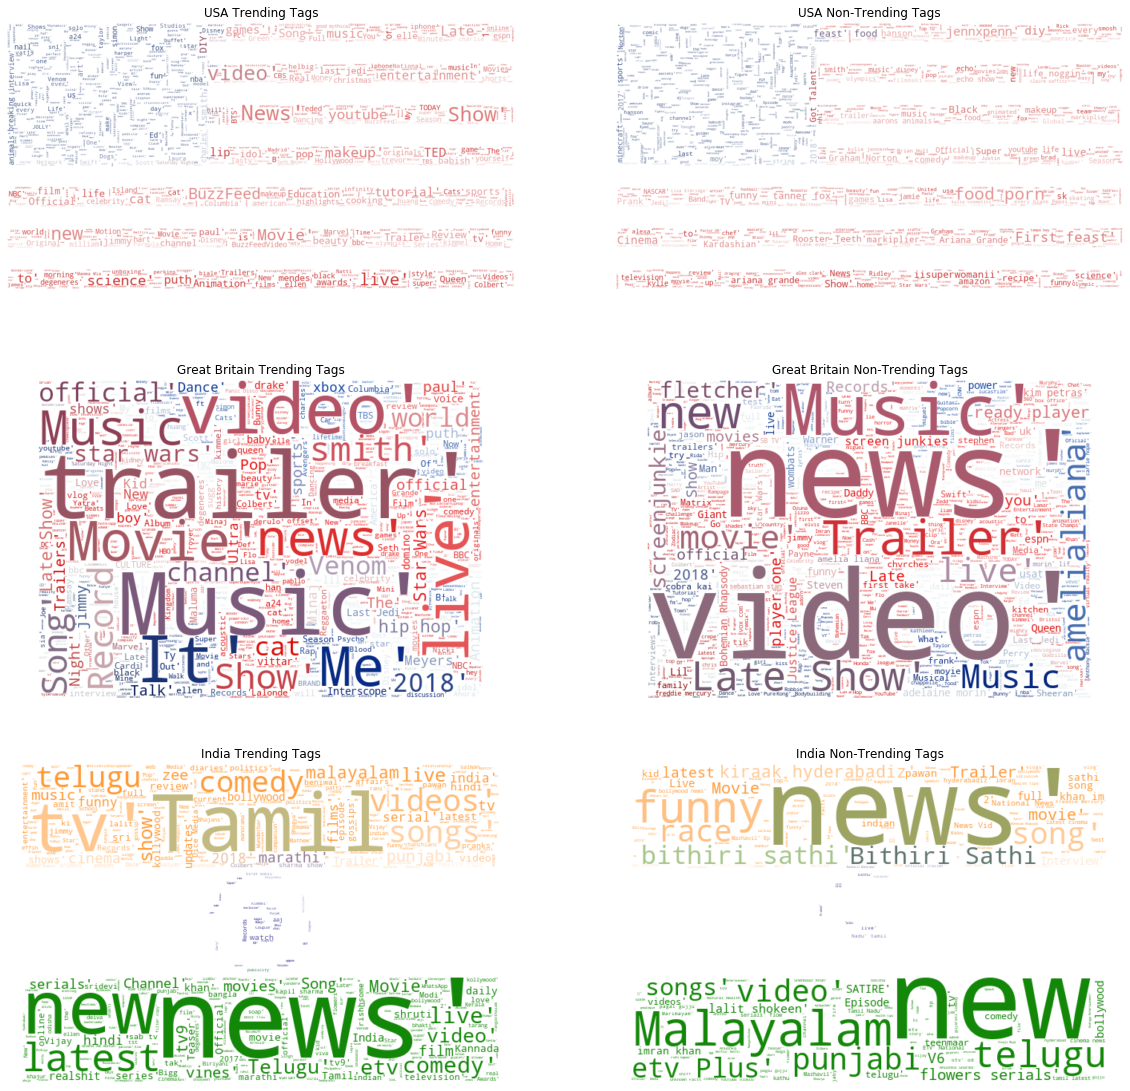

<Figure size 1440x1440 with 0 Axes>

In [139]:
## written by Aravind Patnam


## wordcloud visualization on countries with most top tags

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

links = ['https://cdn.pixabay.com/photo/2017/03/14/21/00/american-flag-2144392_960_720.png', 
        'https://i.pinimg.com/originals/93/85/dd/9385dde0f8cf96e0c60e5e659036b303.jpg',
        'https://cdn.britannica.com/97/1597-004-7C2918C6/Flag-India.jpg']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
mask_USA = np.array(Image.open(requests.get(links[0], stream=True).raw))
mask_GB = np.array(Image.open(requests.get(links[1], stream=True).raw))
mask_IN = np.array(Image.open(requests.get(links[2], stream=True).raw))
image_colors_usa = ImageColorGenerator(mask_USA)
image_colors_gb = ImageColorGenerator(mask_GB)
image_colors_in = ImageColorGenerator(mask_IN)
wordcloud_usa_trending = WordCloud(width=1000, height=1000, mask=mask_USA, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(us_trending_most_common_tags.keys())))
wordcloud_gb_trending = WordCloud(width=1000, height=1000, mask=mask_GB, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(gb_trending_most_common_tags.keys())))
wordcloud_in_trending = WordCloud(width=1000, height=1000, mask=mask_IN, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(in_trending_most_common_tags.keys())))


wordcloud_usa_nontrending = WordCloud(width=1000, height=1000, mask=mask_USA, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(us_nontrending_most_common_tags.keys())))
wordcloud_gb_nontrending = WordCloud(width=1000, height=1000, mask=mask_GB, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(gb_nontrending_most_common_tags.keys())))
wordcloud_in_nontrending = WordCloud(width=1000, height=1000, mask=mask_IN, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(in_nontrending_most_common_tags.keys())))


plt.figure(figsize=(20,20), facecolor='k')

axes[0, 0].imshow(wordcloud_usa_trending.recolor(color_func=image_colors_usa), interpolation="bilinear")
axes[0, 0].set_title("USA Trending Tags")
axes[0, 0].axis("off")

axes[1, 0].imshow(wordcloud_gb_trending.recolor(color_func=image_colors_gb), interpolation="bilinear")
axes[1, 0].set_title("Great Britain Trending Tags")
axes[1, 0].axis("off")


axes[2, 0].imshow(wordcloud_in_trending.recolor(color_func=image_colors_in), interpolation="bilinear")
axes[2, 0].set_title("India Trending Tags")
axes[2, 0].axis("off")

axes[0, 1].imshow(wordcloud_usa_nontrending.recolor(color_func=image_colors_usa), interpolation="bilinear")
axes[0, 1].set_title("USA Non-Trending Tags")
axes[0, 1].axis("off")


axes[1, 1].imshow(wordcloud_gb_nontrending.recolor(color_func=image_colors_gb), interpolation="bilinear")
axes[1, 1].set_title("Great Britain Non-Trending Tags")
axes[1, 1].axis("off")




axes[2, 1].imshow(wordcloud_in_nontrending.recolor(color_func=image_colors_in), interpolation="bilinear")
axes[2, 1].set_title("India Non-Trending Tags")
axes[2, 1].axis("off")



plt.tight_layout(pad=0)
plt.show()

In [140]:
## written by Aravind Patnam

## do sentiment analysis on each of the tags
## return classifications on each of the tags in both trending and non-trending per country
positive_words_df = pd.read_fwf('positivewords.txt')
negative_words_df = pd.read_fwf('negativewords.txt')

def extract_features(words):
    return dict([(word, True) for word in words.split()])

def build_sentiment_analysis_model():
    positive_words = positive_words_df['positivewords'].values.tolist()
    negative_words = negative_words_df['negativewords'].values.tolist()
    pos_feats = [(extract_features(f), 'positive') for f in positive_words ]
    neg_feats = [(extract_features(f), 'negative') for f in negative_words ]
    dataset = pos_feats + neg_feats
    random.shuffle(dataset)
    cutoff = int(0.80 * len(dataset))
    train_data = dataset[:cutoff]
    test_data = dataset[cutoff:]

    classifier = NaiveBayesClassifier.train(train_data)
    print("Accuracy is:", classify.accuracy(classifier, test_data))
    # print(classifier.show_most_informative_features(10))
    return classifier

def execute_model(tags):
    classifications = {}
    classifier = build_sentiment_analysis_model()
    # classifier.show_most_informative_features(5)
    for tag in tags:
        classified = classifier.classify(extract_features(tag))
        classifications[tag] = classified
    return classifications

In [141]:
## written by Aravind Patnam

## gets the classifications from the sentiment analysis and prints out accuracies of the model
classifications_us_trending = execute_model(list(us_trending_most_common_tags.keys()))
classifications_ca_trending = execute_model(list(ca_trending_most_common_tags.keys()))
classifications_de_trending = execute_model(list(de_trending_most_common_tags.keys()))
classifications_fr_trending = execute_model(list(fr_trending_most_common_tags.keys()))
classifications_gb_trending = execute_model(list(gb_trending_most_common_tags.keys()))
classifications_in_trending = execute_model(list(in_trending_most_common_tags.keys()))
classifications_jp_trending = execute_model(list(jp_trending_most_common_tags.keys()))
classifications_kr_trending = execute_model(list(kr_trending_most_common_tags.keys()))
classifications_mx_trending = execute_model(list(mx_trending_most_common_tags.keys()))
classifications_ru_trending = execute_model(list(ru_trending_most_common_tags.keys()))

classifications_us_nontrending = execute_model(list(us_nontrending_most_common_tags.keys()))
classifications_ca_nontrending = execute_model(list(ca_nontrending_most_common_tags.keys()))
classifications_de_nontrending = execute_model(list(de_nontrending_most_common_tags.keys()))
classifications_fr_nontrending = execute_model(list(fr_nontrending_most_common_tags.keys()))
classifications_gb_nontrending = execute_model(list(gb_nontrending_most_common_tags.keys()))
classifications_in_nontrending = execute_model(list(in_nontrending_most_common_tags.keys()))
classifications_jp_nontrending = execute_model(list(jp_nontrending_most_common_tags.keys()))
classifications_kr_nontrending = execute_model(list(kr_nontrending_most_common_tags.keys()))
classifications_mx_nontrending = execute_model(list(mx_nontrending_most_common_tags.keys()))
classifications_ru_nontrending = execute_model(list(ru_nontrending_most_common_tags.keys()))

Accuracy is: 0.6348573181957655
Accuracy is: 0.6403804848112918
Accuracy is: 0.63577784596502
Accuracy is: 0.6416078551702976
Accuracy is: 0.6400736422215404
Accuracy is: 0.6336299478367597
Accuracy is: 0.6520405032218471
Accuracy is: 0.6413010125805462
Accuracy is: 0.6501994476833385
Accuracy is: 0.6293341515802393
Accuracy is: 0.6508131328628414
Accuracy is: 0.6520405032218471
Accuracy is: 0.6449831236575637
Accuracy is: 0.6443694384780607
Accuracy is: 0.649278919914084
Accuracy is: 0.6348573181957655
Accuracy is: 0.6311752071187481
Accuracy is: 0.6449831236575637
Accuracy is: 0.6489720773243326
Accuracy is: 0.6330162626572569


In [142]:
## written by Aravind Patnam

## pulls actual statistics from classifications for visualization
def get_sentiment_stats(classification, country):
    sentiments = list(classification.values())
    sentiments_df = pd.DataFrame(sentiments, columns=['Sentiment'])
    negatives = len(sentiments_df[sentiments_df['Sentiment'] =='negative'])
    positives = len(sentiments_df[sentiments_df['Sentiment'] =='positive'])
    total_len = len(sentiments_df)
    percentage_of_negative = negatives / total_len * 100
    percentage_of_positive = positives / total_len * 100
    ratio = positives/negatives
    # ratioStr = "{} positive/negative ratio: {} -----> {}% positives of total , {}% negatives of total".format(country, ratio, percentage_of_positive, percentage_of_negative)
    # print (ratioStr)
    return country, positives, negatives

In [143]:
## written by Aravind Patnam

## calls above method for stats for each country for visualization

country_us_trending, us_trending_pos, us_trending_neg = get_sentiment_stats(classifications_us_trending, "USA_Trending")
country_ca_trending, ca_trending_pos, ca_trending_neg = get_sentiment_stats(classifications_ca_trending, "Canada_Trending")
country_de_trending, de_trending_pos, de_trending_neg = get_sentiment_stats(classifications_de_trending, "Denmark_Trending")
country_fr_trending, fr_trending_pos, fr_trending_neg = get_sentiment_stats(classifications_fr_trending, "France_Trending")
country_gb_trending, gb_trending_pos, gb_trending_neg = get_sentiment_stats(classifications_gb_trending, "GreatBritain_Trending")
country_in_trending, in_trending_pos, in_trending_neg = get_sentiment_stats(classifications_in_trending, "India_Trending")
country_jp_trending, jp_trending_pos, jp_trending_neg = get_sentiment_stats(classifications_jp_trending, "Japan_Trending")
country_kr_trending, kr_trending_pos, kr_trending_neg = get_sentiment_stats(classifications_kr_trending, "SouthKorea_Trending")
country_mx_trending, mx_trending_pos, mx_trending_neg = get_sentiment_stats(classifications_mx_trending, "Mexico_Trending")
country_ru_trending, ru_trending_pos, ru_trending_neg = get_sentiment_stats(classifications_ru_trending, "Russia_Trending")


country_us_nontrending, us_nontrending_pos, us_nontrending_neg = get_sentiment_stats(classifications_us_nontrending, "USA_NonTrending")
country_ca_nontrending, ca_nontrending_pos, ca_nontrending_neg = get_sentiment_stats(classifications_ca_nontrending, "Canada_NonTrending")
country_de_nontrending, de_nontrending_pos, de_nontrending_neg = get_sentiment_stats(classifications_de_nontrending, "Denmark_NonTrending")
country_fr_nontrending, fr_nontrending_pos, fr_nontrending_neg = get_sentiment_stats(classifications_fr_nontrending, "France_NonTrending")
country_gb_nontrending, gb_nontrending_pos, gb_nontrending_neg = get_sentiment_stats(classifications_gb_nontrending, "GreatBritain_NonTrending")
country_in_nontrending, in_nontrending_pos, in_nontrending_neg = get_sentiment_stats(classifications_in_nontrending, "India_NonTrending")
country_jp_nontrending, jp_nontrending_pos, jp_nontrending_neg = get_sentiment_stats(classifications_jp_nontrending, "Japan_NonTrending")
country_kr_nontrending, kr_nontrending_pos, kr_nontrending_neg = get_sentiment_stats(classifications_kr_nontrending, "SouthKorea_NonTrending")
country_mx_nontrending, mx_nontrending_pos, mx_nontrending_neg = get_sentiment_stats(classifications_mx_nontrending, "Mexico_NonTrending")
country_ru_nontrending, ru_nontrending_pos, ru_nontrending_neg = get_sentiment_stats(classifications_ru_nontrending, "Russia_NonTrending")

countries = [country_us_trending, country_ca_trending, country_de_trending, country_fr_trending, country_gb_trending,
            country_in_trending, country_jp_trending, country_kr_trending, country_mx_trending, country_ru_trending,
            country_us_nontrending, country_ca_nontrending, country_de_nontrending, country_fr_nontrending, 
            country_gb_nontrending, country_in_nontrending, country_jp_nontrending, country_kr_nontrending, 
            country_mx_nontrending, country_ru_nontrending]
positivePercenteages = [us_trending_pos, ca_trending_pos, de_trending_pos, fr_trending_pos, gb_trending_pos, in_trending_pos, jp_trending_pos,
            kr_trending_pos, mx_trending_pos, ru_trending_pos, us_nontrending_pos, ca_nontrending_pos, de_nontrending_pos, fr_nontrending_pos,
            gb_nontrending_pos, in_nontrending_pos, jp_nontrending_pos, kr_nontrending_pos, mx_nontrending_pos, ru_nontrending_pos]
negativePercentages = [us_trending_neg, ca_trending_neg, de_trending_neg, fr_trending_neg, gb_trending_neg, in_trending_neg, jp_trending_neg, 
                      kr_trending_neg, mx_trending_neg, ru_trending_neg, us_nontrending_neg, ca_nontrending_neg, de_nontrending_neg, 
                      fr_nontrending_neg, gb_nontrending_neg, in_nontrending_neg, jp_nontrending_neg, kr_nontrending_neg, mx_nontrending_neg,
                      ru_nontrending_neg]
posToNegRatios = [i / j for i, j in zip(positivePercenteages, negativePercentages)] 
data_dict = {"Country" : countries, "Positives": positivePercenteages, "Negatives": negativePercentages, "PositiveNegativeRatio": posToNegRatios}
data = pd.DataFrame(data_dict, columns = ['Country', 'Positives' , 'Negatives', 'PositiveNegativeRatio'])

data
## visualize these!!! 

,Country,Positives,Negatives,PositiveNegativeRatio
0,USA_Trending,167,833,0.200480
1,Canada_Trending,209,791,0.264223
2,Denmark_Trending,179,821,0.218027
3,France_Trending,119,881,0.135074
4,GreatBritain_Trending,192,808,0.237624
5,India_Trending,291,709,0.410437
6,Japan_Trending,89,911,0.097695
7,SouthKorea_Trending,77,923,0.083424
8,Mexico_Trending,133,867,0.153403
9,Russia_Trending,121,879,0.137656


Hover over the plots and switch table to play with them and see what each one represents!! Use the toolbar to crop out some plots for better analysis. 

In [144]:
## written by Aravind Patnam

## visualizes sentiment analysis ratios

## import pandas as pd
import bokeh.plotting as bp
from bokeh.models import HoverTool, ColorBar, NumeralTickFormatter, LinearColorMapper, LassoSelectTool, ResetTool, PanTool, BoxSelectTool, TapTool, PolySelectTool
from bokeh.palettes import plasma
from bokeh.plotting import figure
from bokeh.transform import transform
import bokeh.io
import bokeh.plotting as bpl
import bokeh.models as bmo
from bokeh.palettes import d3
from bokeh.transform import linear_cmap
from bokeh.models import SingleIntervalTicker, LinearAxis
from bokeh.layouts import gridplot

bokeh.io.reset_output()
bokeh.io.output_notebook()
mySource = bp.ColumnDataSource(data)
#Use the field name of the column source
mapper = linear_cmap(field_name='Positives', palette="Spectral6" ,low=max(list(data['Positives']) + list(data['Negatives'])) ,high=min(list(data['Positives']) + list(data['Negatives'])))

hover = HoverTool()
hover.tooltips = [
    ("Country", "@Country"),
    ("Ratio" , "@PositiveNegativeRatio"),
    ("Positives", "@Positives"),
    ("Negatives" , "@Negatives")
]
myPlot = bp.figure(
               title = 'Positives vs. Negatives',
               plot_height=500,
               plot_width=500, 
    tools = [BoxSelectTool(), LassoSelectTool(), ResetTool(), hover, TapTool(), PolySelectTool()], 
    background_fill_color = "black",
    x_axis_label = 'Positives', y_axis_label = 'Negatives',
x_range=(0, 1000), y_range=(0, 1000))
myPlot.title.text_font_size = '20pt'
myPlot.xaxis.axis_label_text_font_size = "20pt"
myPlot.yaxis.axis_label_text_font_size = "20pt"
myPlot.xaxis.ticker = SingleIntervalTicker(interval=50)
myPlot.yaxis.ticker = SingleIntervalTicker(interval=50)
myPlot.circle("Positives",
          "Negatives",
              line_color=mapper,color=mapper, fill_alpha=1, 
          source=mySource,
          size = 12,
             selection_color='deepskyblue',
           nonselection_color='lightgray',
             hover_fill_color='yellow', hover_alpha=2.0)
color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))

myPlot.add_layout(color_bar, 'right')


from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.palettes import Category20
from bokeh.models import Legend

bokeh.io.reset_output()
bokeh.io.output_notebook()


countries = list(data['Country'])
hover = HoverTool(
    tooltips=[
        ("Ratio", "@top")
    ]
)

colors = ['red', 'red', 'red', 'red',
          'red', 'red', 'red', 'red',
          'red', 'red', 'green', 'green', 'green', 'green',
          'green', 'green', 'green', 'green',
          'green', 'green']


p = figure(x_range=countries, plot_height=500, title="Sentiment Analysis Ratios", width = 500,  background_fill_color = "black")
legends = ['Trending', 'Not Trending']
v = p.vbar(x=countries, top=list(data['PositiveNegativeRatio']), width=0.5, color=colors)
v1 = p.vbar(x=countries, top=list(data['PositiveNegativeRatio']), width=0.5, color='green')
p.add_layout(Legend(items=[
        ("Trending"   , [v]),
        ("NonTrending" , [v1]),
    ]))
v1.visible = False

p.add_tools(hover)
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = -1.5
p.xaxis.axis_label = "Countries"
p.yaxis.axis_label = "Ratio of Positive:Negative"
p.xgrid.grid_line_color = None

p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"



# Bokeh Library
from bokeh.io import output_file
from bokeh.models.widgets import Tabs, Panel


# Increase the plot widths
myPlot.plot_width = p.plot_width = 1000

# Create two panels, one for each conference
myPlotPanel = Panel(child=myPlot, title='Positives vs. Negatives')
pPanel = Panel(child=p, title='Sentiment Analysis Ratios')

# Assign the panels to Tabs
tabs = Tabs(tabs=[pPanel, myPlotPanel])

# Show the tabbed layout
show(tabs)

Loading BokehJS ...

Loading BokehJS ...

In [145]:
## written by Aravind Patnam


## lda model prep for topic model inference from youtube tags and description accross trending and nontrending videos

import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

def prepare_text_for_lda(text):
    tokens = tokenize(str(text))
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

[nltk_data] Downloading package wordnet to /Users/aravind/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aravind/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
## written by Aravind Patnam

## method to execute LDA model and clean the LDA input one more time

import random
from gensim import corpora
import gensim
import pickle
def do_LDA(lda_input):
    text_data = []
    for line in lda_input:
        tokens = prepare_text_for_lda(line)
        if random.random() > .99:
            text_data.append(tokens)
    topics, corpus, dictionary = execute_LDA(text_data)
    return topics, corpus, dictionary
    
def execute_LDA(text_data):
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=10)
    return topics, corpus, dictionary

import re
def clean_lda_input(input):
    l = []
    for a in input:
        text = re.sub(r"http\S+", "", str(a))
        l.append(text)
    return l

In [147]:
## written by Aravind Patnam

## visualize LDA using pyLDAvis -> this might be only visible on nbviewer depending on your notebook viewing settings

def visualize_LDA(start, corpus, dictionary):
    if (start == True):
        lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
        lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
        return lda_display

Hover and play around with the principle component analysis presented below. LDA topic model was used on youtube tags and descriptions to show these findings. The relevancy metric at the time of this submission is set to around 0.30 since it showed the most favorable results that were not too specific and not too generic. 

In [148]:
## written by Aravind Patnam

## this will take a long time to run!

## visualize trending videos using pyLDAvis -> this might be only visible on nbviewer depending on your notebook viewing settings

full_trending_lda_input = list(get_most_common_tags(full_trending_df).keys()) + list (full_trending_df.sample(16901)['description'])
topics_Full_Trending, corpus, dictionary = do_LDA(full_trending_lda_input)
lda_display = visualize_LDA(True, corpus, dictionary)
pyLDAvis.display(lda_display)

In [149]:
## written by Aravind Patnam

## this will take a long time to run!

## visualize nontrending videos using pyLDAvis -> this might be only visible on nbviewer depending on your notebook viewing settings


full_nontrending_lda_input = list(get_most_common_tags(full_nontrending_df).keys()) + list (full_nontrending_df['description'])
topics_Full_Nontrending, corpus, dictionary = do_LDA(full_nontrending_lda_input)
lda_display = visualize_LDA(True, corpus, dictionary)
pyLDAvis.display(lda_display)

In [150]:
## written by Aravind Patnam

## this will take a long time to run!

## visualize all videos using pyLDAvis -> this might be only visible on nbviewer depending on your notebook viewing settings

allDfsDf_lda_input = list(get_most_common_tags(allDfsDf).keys()) + list (allDfsDf.sample(100000)['description'])
topics_all_dfs, corpus, dictionary = do_LDA(allDfsDf_lda_input)
lda_display = visualize_LDA(True, corpus, dictionary)
pyLDAvis.display(lda_display)

In [36]:
## written by Aravind Patnam

## no need to run this as this has already been done for you

## convert to csvs

not_trending_us_df.to_csv('not_trending_us_df.csv')
not_trending_ca_df.to_csv('not_trending_ca_df.csv')
not_trending_de_df.to_csv('not_trending_de_df.csv')
not_trending_fr_df.to_csv('not_trending_fr_df.csv')
not_trending_gb_df.to_csv('not_trending_gb_df.csv')
not_trending_in_df.to_csv('not_trending_in_df.csv')
not_trending_jp_df.to_csv('not_trending_jp_df.csv')
not_trending_kr_df.to_csv('not_trending_kr_df.csv')
not_trending_mx_df.to_csv('not_trending_mx_df.csv')
not_trending_ru_df.to_csv('not_trending_ru_df.csv')